# COVID-19 Daily State Tracking

This Juptyer Notebook is © 2020 Stacey Adams and is available under the  [MIT License](https://choosealicense.com/licenses/mit/).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Set the state you wish to process here

In [2]:
state = 'MO'

### State Abbreviation Table (collapsed by default)

In [3]:
# United States of America Python Dictionary to translate States,
# Districts & Territories to Two-Letter codes and vice versa.
#
# https://gist.github.com/rogerallen/1583593
#
# Dedicated to the public domain.  To the extent possible under law,
# Roger Allen has waived all copyright and related or neighboring
# rights to this code.

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico Commonwealth': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# thank you to @kinghelix and @trevormarburger for this idea
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

# build a dataframe for later use
state_abbrev = pd.DataFrame(data=abbrev_us_state.values(), index=abbrev_us_state.keys(), columns=["state name"])
state_abbrev.index.names = ['state']
#state_abbrev.head(5)

## Read the daily state data from covidtracking.com

The COVID Tracking Project data is published under a [Creative Commons CC BY-NC-4.0 license](http://creativecommons.org/licenses/by-nc/4.0/).

In [4]:
data_url = "http://covidtracking.com/api/states/daily.csv"
corona = pd.read_csv(data_url, parse_dates=['date'])
corona.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,2020-08-03,AK,4064.0,241743.0,NaN,38.0,NaN,NaN,NaN,4.0,...,245807,1,0,890afec5cf195d314c578f8709ac457553a5acdb,0,0,0,0,0,NaN
1,2020-08-03,AL,92661.0,621390.0,NaN,1517.0,10865.0,NaN,1153.0,NaN,...,714051,6,344,e2c9f30805eee72254984ba76c01fd4d5d4baca4,0,0,0,0,0,NaN
2,2020-08-03,AR,44597.0,482803.0,NaN,513.0,2966.0,NaN,NaN,108.0,...,527400,17,72,a5dde28205d14b46b4ca50a97b96cef8c6a3770e,0,0,0,0,0,NaN
3,2020-08-03,AS,0.0,1267.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1267,0,0,6ac3b3dfcfdb6433bf96d9b1b7dfae9d28d21891,0,0,0,0,0,NaN
4,2020-08-03,AZ,179497.0,784921.0,NaN,2017.0,11400.0,628.0,NaN,461.0,...,964418,14,29,9591393f2723f5245eb0a913e9ba03e05f7ce0bd,0,0,0,0,0,NaN


## Read population data from US Census Bureau

US Census Bureau data is public domain.

In [5]:
population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv", usecols=['NAME', 'POPESTIMATE2019'])
population.rename(columns={"NAME": "state name", "POPESTIMATE2019": "2019 population estimate"}, inplace=True)
# data missing from url above; manually retrieved from CIA World Factbook (and provided by the US Census Bureau)
islands = pd.DataFrame([['American Samoa', 55_212], ['Guam', 168_485], ['Northern Mariana Islands', 51_433], ['Virgin Islands', 106_235]], columns=['state name', '2019 population estimate'])
population = population.append(islands)

## Display National and State Totals

In [6]:
national_data = corona.agg({'positiveIncrease' : ['sum'], 'deathIncrease' : ['sum']})
national_data.rename(columns={"positiveIncrease": "total cases", "deathIncrease": "total deaths"}, index={"sum": "United States"}, inplace=True)
national_data.index.names = ['state name']
national_with_pop = pd.merge(national_data, population, on='state name', how='left')
national_with_pop['cases per 100k pop'] = (national_with_pop['total cases'] * 100_000 / national_with_pop['2019 population estimate']).round(2)
national_with_pop['mortality rate'] = (national_with_pop['total deaths'] * 100 / national_with_pop['total cases']).round(2)
national_with_pop

,state name,total cases,total deaths,2019 population estimate,cases per 100k pop,mortality rate
0,United States,4694009,147653,328239523,1430.06,3.15


In [7]:
state_totals = corona.groupby(by="state").sum()
state_totals.rename(columns={"positiveIncrease": "total cases", "deathIncrease": "total deaths"}, inplace=True)
state_totals = pd.merge(state_abbrev, state_totals[["total cases", "total deaths"]], on='state')
state_with_pop = pd.merge(state_totals, population, on='state name', how='left')
state_with_pop['cases per 100k pop'] = (state_with_pop['total cases'] * 100_000 / state_with_pop['2019 population estimate']).round(2)
state_with_pop['mortality rate'] = (state_with_pop['total deaths'] * 100 / state_with_pop['total cases']).round(2)
state_with_pop

,state name,total cases,total deaths,2019 population estimate,cases per 100k pop,mortality rate
0,Alabama,92661,1633,4903185,1889.81,1.76
1,Alaska,4064,25,731545,555.54,0.62
2,American Samoa,0,0,55212,0.00,NaN
3,Arizona,179495,3779,7278717,2466.03,2.11
4,Arkansas,44597,475,3017804,1477.80,1.07
5,California,514848,9388,39512223,1303.01,1.82
6,Colorado,47716,1691,5758736,828.58,3.54
7,Connecticut,50062,4437,3565287,1404.15,8.86
8,Delaware,15055,585,973764,1546.06,3.89
9,District of Columbia,12313,586,705749,1744.67,4.76


In [8]:
state_name = abbrev_us_state[state]
state_with_pop.query("`state name`==@state_name")

,state name,total cases,total deaths,2019 population estimate,cases per 100k pop,mortality rate
27,Missouri,52887,1255,6137428,861.71,2.37


## Extract the state data and add 7-day averages

In [9]:
state_data = corona.query("state==@state")
pd.set_option('mode.chained_assignment',None) # don't display the SettingWithCopyWarning triggered by the next lines
state_data['7dayAverage'] = state_data.positiveIncrease.rolling(7).mean().shift(-3)
state_data['7DayAvgDeaths'] = state_data.deathIncrease.rolling(7).mean().shift(-3)
state_data[['date', 'positiveIncrease', '7dayAverage', 'deathIncrease', '7DayAvgDeaths']].head(5)

,date,positiveIncrease,7dayAverage,deathIncrease,7DayAvgDeaths
26,2020-08-03,1047,NaN,2,NaN
82,2020-08-02,582,NaN,0,NaN
138,2020-08-01,935,NaN,10,NaN
194,2020-07-31,1489,1405.285714,10,7.714286
250,2020-07-30,2084,1416.142857,13,8.000000


## Display a time series plot for Daily Cases

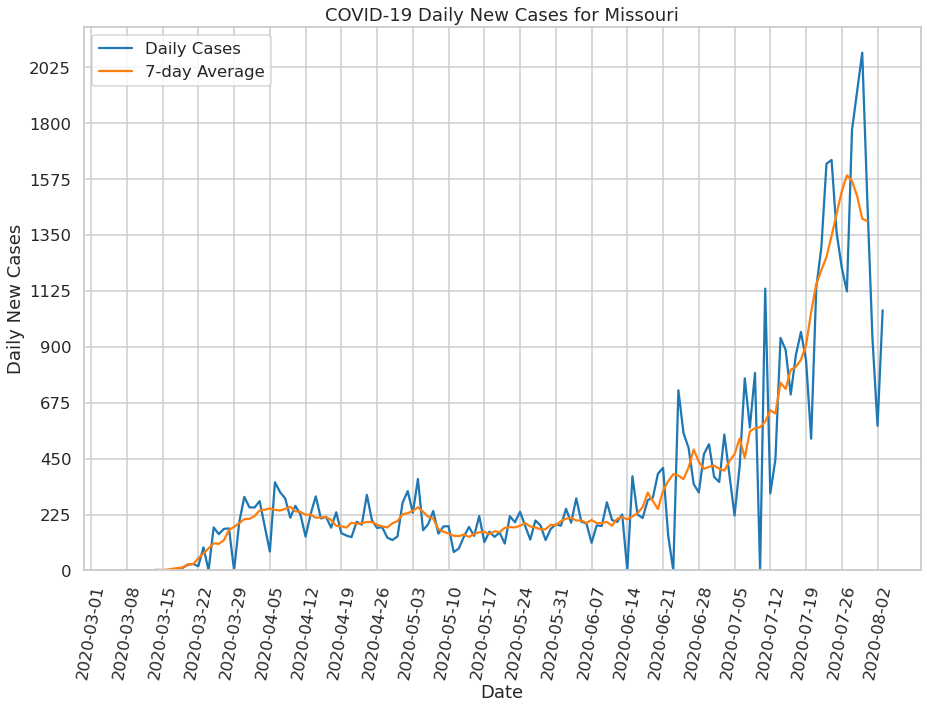

In [10]:
# use plot elements suitable for talks
sns.set_context("talk")
sns.set_style("whitegrid")
# set figure size
plt.figure(figsize=(15,10))
# Time series plot with label
sns.lineplot(x="date", y="positiveIncrease", label="Daily Cases", data=state_data, ci=None)
# 7-day rolling average
sns.lineplot(x="date", y="7dayAverage", label="7-day Average", data=state_data, ci=None)
# set plot elements
plt.title("COVID-19 Daily New Cases for %s" % abbrev_us_state[state])
plt.xlabel("Date")
plt.ylabel("Daily New Cases")
axis = list(plt.axis())
axis[2]=0
plt.axis(axis)
locs, labels = plt.xticks()
plt.xticks(np.arange(locs[0], locs[locs.size-1]+6, 7), rotation=80)
locs, labels = plt.yticks()
plt.yticks(np.arange(0, locs[locs.size-1], locs[locs.size-1] / 10))
plt.show()

## Display a time series plot for Daily Deaths

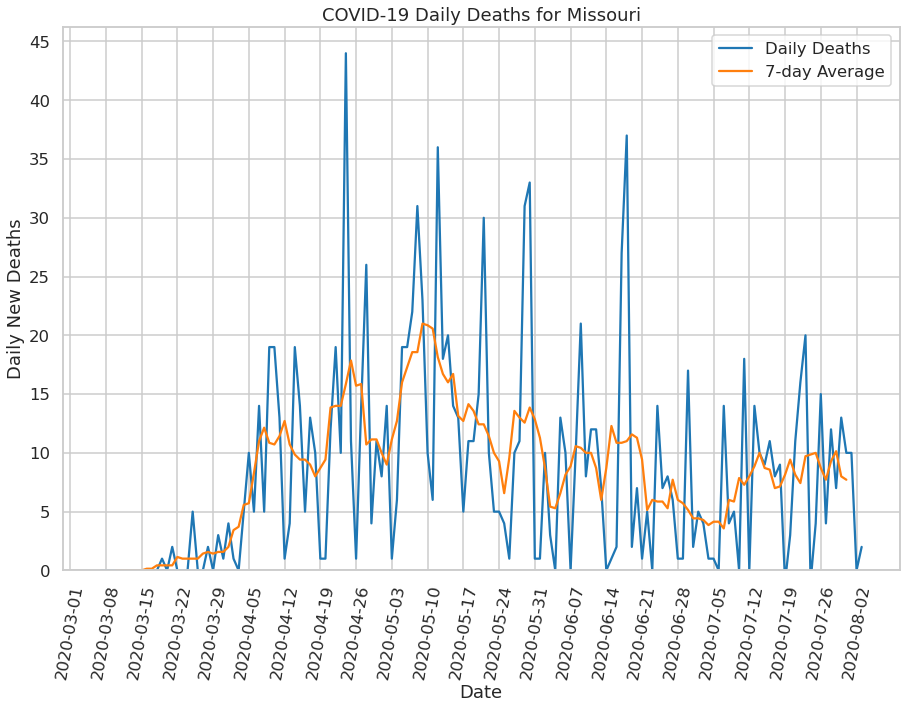

In [11]:
# use plot elements suitable for talks
sns.set_context("talk")
sns.set_style("whitegrid")
# set figure size
plt.figure(figsize=(15,10))
# Time series plot with label
sns.lineplot(x="date", y="deathIncrease", label="Daily Deaths", data=state_data, ci=None)
# 7-day rolling average
sns.lineplot(x="date", y="7DayAvgDeaths", label="7-day Average", data=state_data, ci=None)
# set plot elements
plt.title("COVID-19 Daily Deaths for %s" % abbrev_us_state[state])
plt.xlabel("Date")
plt.ylabel("Daily New Deaths")
axis = list(plt.axis())
axis[2]=0
plt.axis(axis)
locs, labels = plt.xticks()
plt.xticks(np.arange(locs[0], locs[locs.size-1]+6, 7), rotation=80)
locs, labels = plt.yticks()
plt.yticks(np.arange(0, locs[locs.size-1], locs[locs.size-1] / 10))
plt.show()